# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires the DSS version of Vensim
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.1.1](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
#We import various packages that are needed for this assignment

import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.analysis.plotting import lines, Density
from ema_workbench.analysis import plotting, plotting_util
import pyNetLogo

C:\Users\Quint\Anaconda3\envs\gds\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


In [2]:
#In python a predator prey model was constructed
def PredPreyPython(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [3]:
#The python model, its uncertanties and outcome variables are specified 
if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    
    model = Model('PythonPredPrey', function=PredPreyPython)

    model.uncertainties = [ RealParameter('prey_birth_rate', 0.015, 0.035),
                           RealParameter('predation_rate', 0.0005, 0.003),
                           RealParameter('predator_efficiency', 0.001, 0.004),
                           RealParameter('predator_loss_rate', 0.04, 0.08)]

    model.outcomes = [TimeSeriesOutcome('predators'),
                      TimeSeriesOutcome('prey')]

In [4]:
#The netlogo model, its uncertainties and outcome variables are specified. Also run_length and replications were demanded
if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    
    netlogomodel = NetLogoModel("NetlogoPredPrey", wd="./model",
                           model_file='PredPrey.nlogo')
    netlogomodel.uncertainties = [ RealParameter('prey_birth_rate', 0.015, 0.035),
                                   RealParameter('predation_rate', 0.0005, 0.003),
                                   RealParameter('predator_efficiency', 0.001, 0.004),
                                   RealParameter('predator_loss_rate', 0.04, 0.08)]
    
    netlogomodel.run_length=int(365*4)
    netlogomodel.replications=1
    netlogomodel.outcomes = [TimeSeriesOutcome('predators'),
                              TimeSeriesOutcome('prey')]

In [5]:
#the vensim model, its uncertanties and outcome variables are specified.
if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    vensimmodel =PysdModel("VensimPredPrey", mdl_file='./model/PredPrey.mdl')

    vensimmodel.uncertainties = [ RealParameter('prey_birth_rate', 0.015, 0.035),
                                   RealParameter('predation_rate', 0.0005, 0.003),
                                   RealParameter('predator_efficiency', 0.001, 0.004),
                                   RealParameter('predator_loss_rate', 0.04, 0.08)]                 
    
    vensimmodel.outcomes = [TimeSeriesOutcome('predators'),
                              TimeSeriesOutcome('prey')]

In [6]:
#the excel model, its uncertanties and outcome variables are specified. Also the default sheet was demanded.
if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    
    excelmodel = ExcelModel("ExcelPredPrey", wd="./model",
                           model_file='PredPrey.xlsx')
    excelmodel.uncertainties = [ RealParameter('prey_birth_rate', 0.015, 0.035),
                                   RealParameter('predation_rate', 0.0005, 0.003),
                                   RealParameter('predator_efficiency', 0.001, 0.004),
                                   RealParameter('predator_loss_rate', 0.04, 0.08)]
    excelmodel.default_sheet = "Sheet1"                   

    excelmodel.outcomes = [TimeSeriesOutcome('predators'),
                              TimeSeriesOutcome('prey')]

In [7]:
#since we want to compare the various model programs, all models are run with the same ensemble. This enambles a good comparison.
nr_experiments=50
list1=[excelmodel,model,vensimmodel,netlogomodel]
experiments, outcomes = perform_experiments(list1,nr_experiments) 
     

[MainProcess/INFO] performing 50 scenarios * 1 policies * 4 model(s) = 200 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished


In [8]:
#For the plotting.lines function, the outcomes need to be reshaped.
for i in outcomes.keys():
    outcomes[i]=outcomes[i][:,0,:]

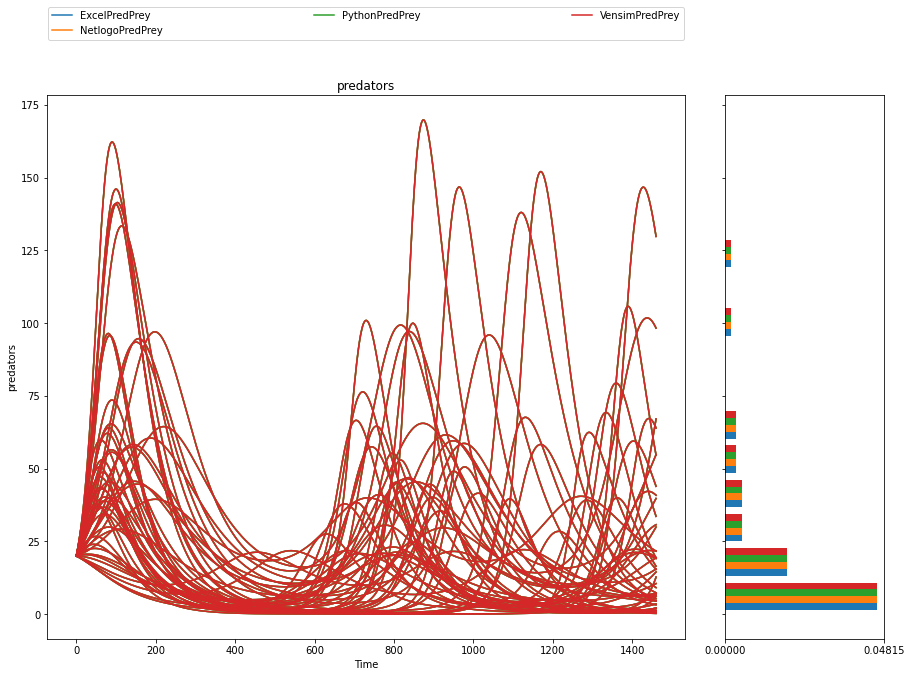

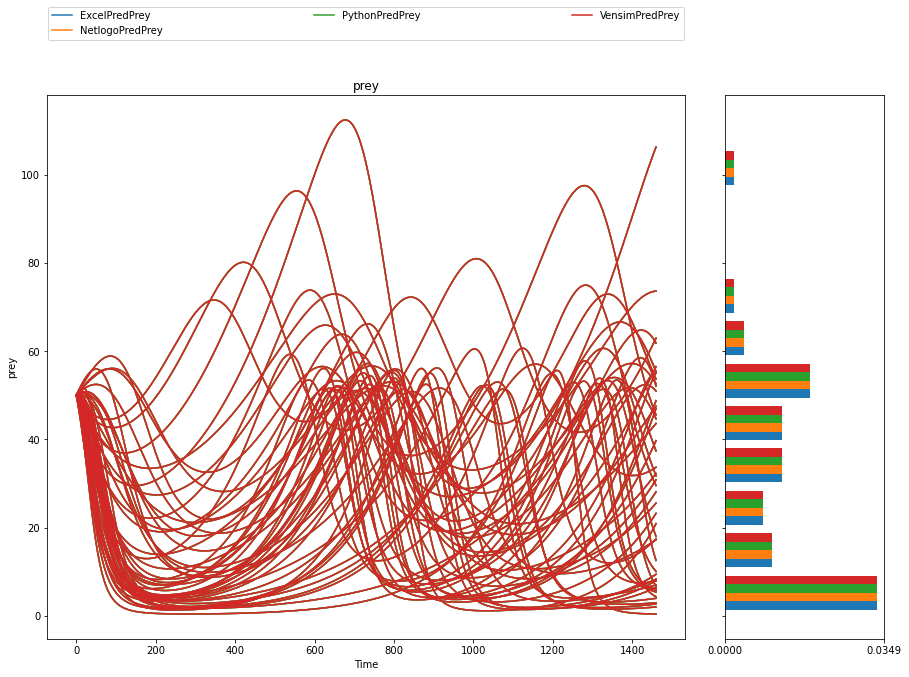

In [9]:
#The various programs lead to similar calculation results
for outcome in outcomes.keys():
    fig,ax=plotting.lines(experiments, outcomes, outcomes_to_show=outcome, 
                   density=plotting_util.Density.HIST,group_by='model')
    fig.set_figheight(10)
    fig.set_figwidth(15)

plt.show()

In [10]:
#To calculate the maximum absolute error we separate the outcomes dictionary. This maximum absolute error gives us a numerical indication of how the various simulation programs differ. 
excel_out_prey=outcomes['prey'][0:50]
python_out_prey=outcomes['prey'][50:100]
vensim_out_prey=outcomes['prey'][100:150]
netlogo_out_prey=outcomes['prey'][150:200]

In [11]:
mae1 = (abs((python_out_prey - vensim_out_prey))).max()
mae2 = (abs((python_out_prey - excel_out_prey))).max()
mae3 = (abs((python_out_prey - netlogo_out_prey))).max()
print("The maximum absolute error of python['prey'] and vensim['prey'] is",mae1)
print("The maximum absolute error of python['prey'] and excel['prey'] is",mae2)
print("The maximum absolute error of python['prey'] and netlogo['prey'] is",mae3)

The maximum absolute error of python['prey'] and vensim['prey'] is 2.5579538487363607e-13
The maximum absolute error of python['prey'] and excel['prey'] is 0.0
The maximum absolute error of python['prey'] and netlogo['prey'] is 7.815970093361102e-13
